In [1]:
import numpy as np
import matplotlib.pyplot as plt
import nbimporter

import central_system as cs
import analyze_control as ac
import read_load as rl

import exp_study_case
import exp_external_conditions
import exp_system_spec
import exp_house_spec
import exp_general_property
import exp_occupant_usage
import exp_circulating_air_flow
import exp_load
import exp_treated_and_untreated_heat
from exp_theoretical_efficiency import get_e_th_h_test, get_e_th_c_test, get_e_th_h, get_e_th_c

# 日本語フォント
import pylab
from matplotlib.font_manager import FontProperties
fp = FontProperties(fname='C:\WINDOWS\Fonts\msgothic.ttc', size = 12)

Importing Jupyter notebook from exp_study_case.ipynb
Importing Jupyter notebook from exp_external_conditions.ipynb
Importing Jupyter notebook from exp_system_spec.ipynb
Importing Jupyter notebook from exp_house_spec.ipynb
Importing Jupyter notebook from exp_general_property.ipynb
Importing Jupyter notebook from exp_occupant_usage.ipynb
Importing Jupyter notebook from exp_circulating_air_flow.ipynb
Importing Jupyter notebook from exp_load.ipynb
Importing Jupyter notebook from exp_treated_and_untreated_heat.ipynb
Importing Jupyter notebook from exp_theoretical_efficiency.ipynb


# 0. 検討ケース

試算するケースを取得します。

In [2]:
case = exp_study_case.get_case()
case

{'region': 6,
 'house': {'a_mr': 29.81,
  'a_or': 51.34,
  'a_a': 120.08,
  'r_env': 2.9555555555555557,
  'insulation': 'h11',
  'solar_gain': 'middle'},
 'system': {'input': 'default',
  'is_duct_insulated': True,
  'vav_system': False,
  'ventilation_included': True,
  'v_hs_rtd_h': None,
  'v_hs_rtd_c': None,
  'cap_rtd_h': None,
  'cap_rtd_c': None}}

1日グラフを描画する日を取得します。

In [3]:
hday, cday = exp_study_case.get_display_day()

## 1. 外部モジュールの読み込み

### 熱源機の仕様

外部モジュール exp_system_spec を参照のこと。

$q_{rtd,H}$：定格暖房能力, W  
$q_{rtd,C}$：定格冷房能力, W  
$V_{hs,rtd,H}$：熱源機の暖房時の定格風量, m<sup>3</sup>/h  
$V_{hs,rtd,C}$：熱源機の冷房時の定格風量, m<sup>3</sup>/h  

In [4]:
input_method, is_duct_insulated, vav_system, ventilation_included, \
    q_rtd_h, q_rtd_c, v_hs_rtd_h, v_hs_rtd_c, p_rtd_h, p_rtd_c, p_fan_rtd_h, p_fan_rtd_c, \
    q_mid_h, q_mid_c, v_hs_mid_h, v_hs_mid_c, p_mid_h, p_mid_c, p_fan_mid_h, p_fan_mid_c \
    = exp_system_spec.get_system_spec(case['region'], case['house']['a_a'], case['system'])
input_method, is_duct_insulated, vav_system, ventilation_included, \
    q_rtd_h, q_rtd_c, v_hs_rtd_h, v_hs_rtd_c, p_rtd_h, p_rtd_c, p_fan_rtd_h, p_fan_rtd_c, \
    q_mid_h, q_mid_c, v_hs_mid_h, v_hs_mid_c, p_mid_h, p_mid_c, p_fan_mid_h, p_fan_mid_c

('default',
 True,
 False,
 True,
 7733.9925600000015,
 7664.646360000001,
 1654.226845584,
 1647.195140904,
 2056.9129148936177,
 2417.8695141955836,
 241.2635794112,
 240.32601878719998,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None)

### 住宅の仕様

外部モジュール exp_house_spec を参照のこと。  

$r_{env}$：床面積の合計に対する外皮の部位の面積の合計の比  
$A_A$：床面積の合計, m<sup>2</sup>  
$A_{MR}$：主たる居室の床面積, m<sup>2</sup>  
$A_{OR}$：その他の居室の床面積, m<sup>2</sup>  
$A_{NR}$：非居室の床面積, m<sup>2</sup>  
$A_{HCZ,R,i}$：標準住戸における暖冷房区画 $i$ の床面積, m<sup>2</sup>  
$A_{HCZ,i}$：暖冷房区画 $i$ の床面積, m<sup>2</sup>  
$A_{prt,i}$：暖冷房区画 $i$ から見た非暖冷房空間の間仕切りの面積, m<sup>2</sup>  
$U_{prt}$：間仕切りの熱貫流率, W/m<sup>2</sup>K  
$Q$：熱損失係数, W/m<sup>2</sup>K  
$\mu_H$：暖房期の日射取得係数, ((W/m<sup>2</sup>)/(W/m<sup>2</sup>))  
$\mu_C$：冷房期の日射取得係数, ((W/m<sup>2</sup>)/(W/m<sup>2</sup>))  
$V_{vent,i}$：暖冷房区画 $i$ の機械換気量, m<sup>3</sup>/h  

In [5]:
r_env, a_a, a_mr, a_or, a_nr, a_hcz, a_prt, u_prt, q, mu_h, mu_c, v_vent = \
    exp_house_spec.get_house_spec(case['region'], case['house'])
r_env, a_a, a_mr, a_or, a_nr, a_hcz, a_prt, u_prt, q, mu_h, mu_c, v_vent

(2.9555555555555557,
 120.08,
 29.81,
 51.34,
 38.92999999999999,
 array([29.81, 16.56, 13.25, 10.76, 10.77,  3.31,  1.66,  3.31, 13.25,
         4.97, 10.77,  1.66]),
 array([37.99636619, 27.7187943 , 22.17838312, 18.01052093, 18.02725933]),
 2.1739130434782608,
 2.7,
 0.101,
 0.062,
 array([60., 20., 40., 20., 20.]))

### 物性値

外部モジュール exp_general_property を参照のこと。

$\rho$：空気の密度, kg/m<sup>3</sup>  
$c$：空気の比熱, J/kgK  
$L_{wtr}$：水の蒸発潜熱, kJ/kg  
「平日」「休日」の別

In [6]:
rho, c, l_wtr, calender = exp_general_property.get_general_property()
rho, c, l_wtr, calender

(1.2,
 1006.0,
 2434.5296000000003,
 array(['休日', '休日', '休日', ..., '休日', '休日', '休日'], dtype=object))

### 気候条件

外部モジュール exp_external_conditions を参照のこと。

$\theta_{ex,d,t}$：日付$d$の時刻$t$における外気温度, ℃  
$x_{ex,d,t}$：日付$d$の時刻$t$における絶対湿度, kg/kg(DA)  
$h_{ex_d,t}$：日付$d$の時刻$t$における相対湿度, %  
$J_{d,t}$：日付$d$の時刻$t$における水平面全天日射量, W/m<sup>2</sup>  
$\theta_{SAT,d,t}$：日付$d$の時刻$t$における水平面における等価外気温度, ℃  

In [7]:
theta_ex, x_ex, h_ex, j, theta_sat = exp_external_conditions.get_external_conditions(case['region'])
theta_ex, x_ex, h_ex, j, theta_sat

(array([2.6, 2.9, 2.8, ..., 3.1, 2.7, 2.3]),
 array([0.0033, 0.0032, 0.0032, ..., 0.0032, 0.0032, 0.0032]),
 array([72.52135498, 68.85197153, 69.34240102, ..., 67.88267058,
        69.83672797, 71.8536949 ]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([2.6, 2.9, 2.8, ..., 3.1, 2.7, 2.3]))

### 居住者の使い方

外部モジュール exp_occupant_usage を参照のこと。

暖冷房期間  
$n_{p,d,t}$：日付$d$の時刻$t$における在室人数  
$q_{gen,d,t}$：日付$d$の時刻$t$における内部発熱, W  
$w_{gen,d,t}$：日付$d$の時刻$t$における内部発湿, g/h  
$V_{local,d,t}$：日付$d$時刻$t$における局所換気量, m<sup>3</sup>/h  
$V_{local,MR,d,t}$：日付$d$時刻$t$における主たる居室の局所換気量, m<sup>3</sup>/h  
$V_{local,OR,d,t}$：日付$d$時刻$t$におけるその他の居室の局所換気量, m<sup>3</sup>/h  
$V_{local,NR,d,t}$：日付$d$時刻$t$における非居室の局所換気量, m<sup>3</sup>/h  
$\theta_{set,h}$：暖房時の設定温度, ℃  
$\theta_{set,c}$：冷房時の設定温度, ℃  
$X_{set,c}$：冷房時の設定絶対湿度, kg/kgDA  

In [8]:
hc_period, n_p, q_gen, w_gen, v_local, v_local_mr, v_local_or, v_local_nr, theta_set_h, theta_set_c, x_set_c \
    = exp_occupant_usage.get_occupant_usage(case['region'], a_mr, a_or, a_nr, calender)
hc_period, n_p, q_gen, w_gen, v_local, v_local_mr, v_local_or, v_local_nr, theta_set_h, theta_set_c, x_set_c

(array(['h', 'h', 'h', ..., 'h', 'h', 'h'], dtype='<U1'),
 array([4., 4., 4., ..., 4., 3., 3.]),
 array([126.4, 126.4, 126.4, ..., 763. , 815. , 242.7]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([  0. ,   0. ,   0. , ...,  25. ,  27. , 100.8]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([  0. ,   0. ,   0. , ...,  25. ,  27. , 100.8]),
 20.0,
 27.0,
 0.013425743)

### 循環風量

外部モジュール exp_circulating_air_flow を参照のこと。

$V'_{supply,d,t,i}$：日付 $d$ の時刻 $t$ における暖冷房区画 $i$ へのVAV調整前の吹き出し風量, m<sup>3</sup>/h  
$V_{hs,min}$：熱源機の最低風量, m<sup>3</sup>/h

In [9]:
v_d_supply, v_hs_min = exp_circulating_air_flow.get_circulating_air_flow(
    a_a, a_hcz, q, mu_h, mu_c, v_vent, theta_ex, x_ex, j, hc_period, ventilation_included, n_p, q_gen, w_gen, v_local,
    theta_set_h, theta_set_c, x_set_c,
    q_rtd_h, q_rtd_c, v_hs_rtd_h, v_hs_rtd_c)
v_d_supply, v_hs_min

(array([[431.73098011, 424.75936241, 427.08323498, ..., 384.98610203,
         397.25927854, 478.51698686],
        [239.83445255, 235.96159146, 237.25254516, ..., 213.86681817,
         220.6847921 , 265.82493467],
        [191.89652756, 188.79777095, 189.83068982, ..., 171.11928386,
         176.57448643, 212.69205219],
        [155.83446313, 153.3180389 , 154.15684698, ..., 138.96177316,
         143.39180936, 172.72199861],
        [155.9792907 , 153.46052778, 154.30011542, ..., 139.09091979,
         143.52507312, 172.88252092]]), 160.0)

### 暖冷房負荷

外部モジュール exp_load を参照のこと。

$\theta_{ac,d,t}$：日付 $d$ の時刻 $t$ における暖冷房室の温度, ℃  
$X_{ac,d,t}$：日付 $d$ の時刻 $t$ における暖冷房室の絶対湿度, kg/kgDA  
$\theta'_{nac,d,t}$：日付 $d$ の時刻 $t$ における負荷バランス時（※）の非暖冷房空間の温度, ℃  
$X'_{nac,d,t}$：日付 $d$ の時刻 $t$ における負荷バランス時（※）の非暖冷房空間の絶対湿度, kg/kgDA  
$L'_{H,d,t,i}$：日付 $d$ の時刻 $t$ における室 $i$ の1時間当たりの負荷バランス時（※）の間仕切り熱損失を含む暖房負荷, MJ/h  
$L'_{CS,d,t,i}$：日付 $d$ の時刻 $t$ における室 $i$ の1時間当たりの負荷バランス時（※）の間仕切り熱取得を含む顕熱冷房負荷, MJ/h  
$L'_{CL,d,t,i}$：日付 $d$ の時刻 $t$ における室 $i$ の1時間当たりの負荷バランス時（※）の間仕切り熱取得を含む潜熱冷房負荷, MJ/h  

In [10]:
theta_ac, x_ac, theta_d_nac, x_d_nac, l_d_h, l_d_cs, l_d_cl = exp_load.get_load(
    case['region'], case['house'], hc_period, theta_ex, x_ex, theta_set_h, theta_set_c, x_set_c,
    q, a_nr, v_local_nr, v_d_supply, u_prt, a_prt)
theta_ac, x_ac, theta_d_nac, x_d_nac, l_d_h, l_d_cs, l_d_cl

(array([20., 20., 20., ..., 20., 20., 20.]),
 array([0.0033, 0.0032, 0.0032, ..., 0.0032, 0.0032, 0.0032]),
 array([18.14819847, 18.13408239, 18.13369986, ..., 18.19891006,
        17.50034825, 18.33028546]),
 array([0.0033, 0.0032, 0.0032, ..., 0.0032, 0.0032, 0.0032]),
 array([[6.25375701, 6.21285461, 6.23357836, ..., 4.87304727, 6.23606361,
         6.2312911 ],
        [2.73031074, 2.72120294, 2.72807592, ..., 2.54324989, 2.80356869,
         2.70500066],
        [1.80262711, 1.78426724, 1.78618363, ..., 2.1278451 , 1.90620444,
         1.78436228],
        [1.67820495, 1.66276464, 1.66718856, ..., 1.14868705, 1.70493067,
         1.65547944],
        [2.08309753, 2.06547907, 2.06983304, ..., 1.56256299, 2.09474812,
         2.05808817]]),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([[-0., -0., -0., ..., -0., -0., -0.],
    

### 処理・未処理熱量

外部モジュール exp_treated_and_untreated_heat を参照のこと。

$\theta_{hs,in,d,t}$：日付 $d$ の時刻 $t$ における熱源機入り口温度, ℃  
$X_{hs,in,d,t}$：日付 $d$ の時刻 $t$ における熱源機入り口絶対湿度, kg/kgDA  
$\theta_{hs,out,H,d,t}$：日付 $d$ の時刻 $t$ における暖房時の熱源機の出口空気温度, ℃  
$\theta_{hs,out,C,d,t}$：日付 $d$ の時刻 $t$ における冷房時の熱源機の出口空気温度, ℃  
$X_{hs,out,C,d,t}$：日付 $d$ の時刻 $t$ における冷房時の熱源機の出口空気絶対湿度, kg/kgDA  
$V_{supply,d,t,i}$：日付 $d$ の時刻 $t$ における暖冷房区画 $i$ への吹き出し風量, m<sup>3</sup>/h  
運転状態：'h'=暖房運転中, 'c'=冷房運転中, 'n'=運転停止中  
$Q_{UT,H,d,t,i}$：日付 $d$ の時刻 $t$ における1時間当たりの暖冷房区画 $i$ に設置された暖房設備機器等の未処理暖房負荷, MJ/h  
$Q_{UT,H,d,t,i}$：日付 $d$ の時刻 $t$ における1時間当たりの暖冷房区画 $i$ に設置された冷房設備機器の未処理冷房顕熱負荷, MJ/h  
$Q_{UT,H,d,t,i}$：日付 $d$ の時刻 $t$ における1時間当たりの暖冷房区画 $i$ に設置された冷房設備機器の未処理冷房潜熱負荷, MJ/h  

In [11]:
theta_hs_in, x_hs_in, theta_hs_out_h, theta_hs_out_c, x_hs_out_c, v_supply, operation, q_ut_h, q_ut_cs, q_ut_cl \
    = exp_treated_and_untreated_heat.get_heat(
        case['region'], a_a, a_hcz, u_prt, a_prt, q, a_nr, q_rtd_h, q_rtd_c,
        theta_sat, theta_ac, x_ac, is_duct_insulated, theta_d_nac, x_d_nac, vav_system,
        hc_period, l_d_h, l_d_cs, l_d_cl, v_d_supply, v_vent, v_local_nr)

In [12]:
theta_hs_in, x_hs_in, theta_hs_out_h, theta_hs_out_c, x_hs_out_c, v_supply, operation, q_ut_h, q_ut_cs, q_ut_cl

(array([18.45523478, 18.44089875, 18.44152019, ..., 18.3499633 ,
        17.78408525, 18.61440392]),
 array([0.0033, 0.0032, 0.0032, ..., 0.0032, 0.0032, 0.0032]),
 array([31.11301145, 31.23123799, 31.1947806 , ..., 30.58410861,
        32.32572968, 29.86998459]),
 array([20., 20., 20., ..., 20., 20., 20.]),
 array([0.0033, 0.0032, 0.0032, ..., 0.0032, 0.0032, 0.0032]),
 array([[431.73098011, 424.75936241, 427.08323498, ..., 384.98610203,
         397.25927854, 478.51698686],
        [239.83445255, 235.96159146, 237.25254516, ..., 213.86681817,
         220.6847921 , 265.82493467],
        [191.89652756, 188.79777095, 189.83068982, ..., 171.11928386,
         176.57448643, 212.69205219],
        [155.83446313, 153.3180389 , 154.15684698, ..., 138.96177316,
         143.39180936, 172.72199861],
        [155.9792907 , 153.46052778, 154.30011542, ..., 139.09091979,
         143.52507312, 172.88252092]]),
 array(['h', 'h', 'h', ..., 'h', 'h', 'h'], dtype='<U1'),
 array([[0.94253407, 0.9393

## 2. 試験時の圧縮機の圧縮効率と能力

### 1-1) 定格暖房能力運転時

$$ \eta_{comp,rtd,H} = \frac{e_{comp,rtd,H}}{e_{comp,th,rtd,H}} $$

$$ e_{comp,rtd,H} = \frac{q_{hs,rtd,H}}{P_{hs,rtd,H} - P_{fan,rtd,H}} $$

$\eta_{comp,rtd,H}$：定格暖房能力運転時における圧縮機の圧縮効率   
$e_{comp,rtd,H}$：定格暖房能力運転時における暖房効率  
$e_{comp,th,rtd,H}$：定格暖房能力運転時における冷凍サイクルの理論暖房効率  
$q_{hs,rtd,H}$：空調機の定格暖房能力, W  
$P_{hs,rtd,H}$：空調機の定格暖房消費電力, W   
$P_{fan,rtd,H}$：定格暖房能力運転時における送風機の消費電力, W   

ここで、定格暖房能力運転時における冷凍サイクルの理論暖房効率$e_{comp,th,H,rtd}$は、外気温度 $ \theta_{ex} $ は7℃、顕熱暖房能力 $ q_{hs,H} $ は定格暖房能力能力 $ q_{hs,H,rtd} $、熱源機の風量 $ V_{hs} $ は定格暖房能力運転時における熱源機の風量 $ V_{fan,H,rtd} $、熱源機入口温度 $ \theta_{hs,in,H} $は20℃に等しいとして、冷凍サイクルの計算（モジュール exp_theoretical_efficiency の「暖房試験時」の計算を参照）により求まるものとする。  
また、$\eta_{comp,rtd,H}$は、0.0未満の場合は0.0、1.0より大の場合は1.0とする。

In [13]:
eta_comp_rtd_h, e_comp_rtd_h, e_comp_th_rtd_h, theta_ref_evp_h, theta_ref_cnd_h = \
    cs.get_comp_eta_rtd_h(q_rtd_h, v_hs_rtd_h, p_rtd_h, p_fan_rtd_h)
eta_comp_rtd_h, e_comp_rtd_h, e_comp_th_rtd_h, theta_ref_evp_h, theta_ref_cnd_h

(0.6123489806958877,
 4.259628998209107,
 6.956211461915662,
 0.21699300638931707,
 38.330069936106824)

### 1-2) 中間暖房能力運転時

空調機の中間暖房能力 $q_{hs,mid,H}$・空調機の中間暖房消費電力 $P_{hs,mid,H}$・中間暖房能力運転時における送風機の消費電力 $P_{fan,mid,H}$ を入力する場合は下式による。   

$$ \eta_{comp,mid,H} = \frac{e_{comp,mid,H}}{e_{comp,th,mid,H}} $$

$$ e_{comp,mid,H} = \frac{q_{hs,mid,H}}{P_{hs,mid,H} - P_{fan,mid,H}} $$

$\eta_{comp,mid,H}$：中間暖房能力運転時における圧縮機の圧縮効率   
$e_{comp,mid,H}$：中間暖房能力運転時における暖房効率  
$e_{comp,th,mid,H}$：中間暖房能力運転時における冷凍サイクルの理論暖房効率  
$q_{hs,mid,H}$：空調機の中間暖房能力, W  
$P_{hs,mid,H}$：空調機の中間暖房消費電力, W   
$P_{fan,mid,H}$：中間暖房能力運転時における送風機の消費電力, W   

ここで、中間暖房能力運転時における冷凍サイクルの理論暖房効率$e_{comp,th,mid,H}$は、外気温度 $ \theta_{ex} $ は7℃、顕熱暖房能力 $ q_{hs,H} $ は中間暖房能力能力 $ q_{hs,mid,H} $、熱源機の風量 $ V_{hs} $ は中間暖房能力運転時における熱源機の風量 $ V_{fan,mid,H} $、熱源機入口温度 $ \theta_{hs,in,H} $は20℃に等しいとして、冷凍サイクルの計算（モジュール exp_theoretical_efficiency の「暖房試験時」の計算を参照）により求まるものとする。  
また、$\eta_{rtd,H}$は、0.0未満の場合は0.0、1.0より大の場合は1.0とする。

空調機の中間暖房能力 $q_{hs,mid,H}$・空調機の中間暖房消費電力 $P_{hs,mid,H}$・中間暖房能力運転時における送風機の消費電力 $P_{fan,mid,H}$ を入力しない場合は下式による。   

$$ \eta_{comp,mid,H} = \eta_{comp,rtd,H} \times 0.95 $$

$\eta_{comp,mid,H}$：中間暖房能力運転時における圧縮機の圧縮効率   
$\eta_{comp,rtd,H}$：定格暖房能力運転時における圧縮機の圧縮効率   

In [14]:
eta_comp_mid_h, e_comp_mid_h, e_comp_th_mid_h, theta_ref_evp_h, theta_ref_cnd_h = cs.get_comp_eta_mid_h(
    input_method, eta_comp_rtd_h, q_mid_h, v_hs_mid_h, p_mid_h, p_fan_mid_h)
eta_comp_mid_h, e_comp_mid_h, e_comp_th_mid_h, theta_ref_evp_h, theta_ref_cnd_h

(0.5817315316610933, None, None, None, None)

また、中間暖房能力 $q_{hs,mid,H}$ は下式による。

$$ q_{hs,mid,H} = q_{hs,rtd,H} \times 0.5 $$

$q_{hs,mid,H}$：中間暖房能力, W  
$q_{hs,rtd,H}$：定格暖房能力, W  

In [15]:
q_mid_h = cs.get_q_hs_mid_h(input_method=input_method, q_hs_rtd_h=q_rtd_h, q_hs_mid_h=q_mid_h)
q_mid_h

3866.9962800000008

### 1-3) 最小暖房能力運転時

$$ \eta_{comp,min,H} = \eta_{comp,rtd,H} \times 0.65 $$

$\eta_{comp,min,H}$：最小暖房能力運転時における圧縮機の圧縮効率   
$\eta_{comp,rtd,H}$：定格暖房能力運転時における圧縮機の圧縮効率   

In [16]:
eta_comp_min_h = cs.get_comp_eta_min_h(eta_comp_rtd_h)
eta_comp_min_h

0.39802683745232703

$$ q_{hs,min,H} = q_{hs,rtd,H} \times 0.35 $$

$q_{hs,min,H}$：最小暖房能力, W  
$q_{hs,rtd,H}$：定格暖房能力, W  

In [17]:
q_min_h = cs.get_q_hs_min_h(q_rtd_h)
q_min_h

2706.8973960000003

### 2-1) 定格冷房能力運転時

$$ \eta_{comp,rtd,C} = \frac{e_{comp,rtd,C}}{e_{comp,th,rtd,C}} $$

$$ e_{comp,rtd,C} = \frac{q_{hs,rtd,C}}{P_{hs,rtd,C} - P_{fan,rtd,C}} $$

$\eta_{comp,rtd,C}$：定格冷房能力運転時における圧縮機の圧縮効率   
$e_{comp,rtd,C}$：定格冷房能力運転時における暖房効率  
$e_{comp,th,rtd,C}$：定格冷房能力運転時における冷凍サイクルの理論暖房効率  
$q_{hs,rtd,C}$：空調機の定格冷房能力, W  
$P_{hs,rtd,C}$：空調機の定格冷房消費電力, W   
$P_{fan,rtd,C}$：定格冷房能力運転時における送風機の消費電力, W  

ここで、定格冷房能力運転時における冷凍サイクルの理論暖房効率$e_{comp,th,rtd,C}$は、外気温度 $ \theta_{ex} $ は35℃、全熱冷房能力 $ q_{hs,C} $ は定格冷房能力 $ q_{hs,rtd,C} $、熱源機の風量 $ V_{hs} $ は定格冷房能力運転時における熱源機の風量 $ V_{fan,rtd,C} $、熱源機入口温度 $ \theta_{hs,in,C} $は27℃、熱源機入口絶対湿度 $X_{hs,in,C}$は 0.010376 kg/kgDA に等しいとして、冷凍サイクルの計算（モジュール exp_theoretical_efficiency の「冷房試験時」の計算を参照）により求まるものとする。  
また、$\eta_{rtd,C}$は、0.0未満の場合は0.0、1.0より大の場合は1.0とする。

In [18]:
eta_comp_rtd_c, e_comp_rtd_c, e_comp_th_rtd_c, theta_ref_evp_c, theta_ref_cnd_c = cs.get_comp_eta_rtd_c(
    q_rtd_c, v_hs_rtd_c, p_rtd_c, p_fan_rtd_c)
eta_comp_rtd_c, e_comp_rtd_c, e_comp_th_rtd_c, theta_ref_evp_c, theta_ref_cnd_c

(0.49055902888716174,
 3.519859133083607,
 7.17519997760197,
 12.402664541518451,
 45.65640286895009)

### 2-2) 中間冷房能力運転時

空調機の中間冷房能力 $q_{hs,mid,C}$・空調機の中間冷房消費電力 $P_{hs,mid,C}$・中間冷房能力運転時における送風機の消費電力 $P_{fan,mid,C}$ を入力する場合は下式による。   

$$ \eta_{comp,mid,C} = \frac{e_{comp,mid,C}}{e_{comp,th,mid,C}} $$

$$ e_{comp,mid,C} = \frac{q_{hs,mid,C}}{P_{hs,mid,C} - P_{fan,mid,C}} $$

$\eta_{comp,mid,C}$：中間冷房能力運転時における圧縮機の圧縮効率   
$e_{comp,mid,C}$：中間冷房能力運転時における暖房効率  
$e_{comp,th,mid,C}$：中間冷房能力運転時における冷凍サイクルの理論暖房効率  
$q_{hs,mid,C}$：空調機の中間冷房能力, W  
$P_{hs,mid,C}$：空調機の中間冷房消費電力, W   
$P_{fan,mid,C}$：中間冷房能力運転時における送風機の消費電力, W   

ここで、中間冷房能力運転時における冷凍サイクルの理論暖房効率$e_{comp,th,mid,C}$は、外気温度 $ \theta_{ex} $ は35℃、全熱冷房能力 $ q_{hs,C} $ は中間冷房能力 $ q_{hs,mid,C} $、熱源機の風量 $ V_{hs} $ は中間冷房能力運転時における熱源機の風量 $ V_{fan,mid,C} $、熱源機入口温度 $ \theta_{hs,in,C} $は27℃、熱源機入口絶対湿度 $X_{hs,in,C}$は 0.010376 kg/kgDA に等しいとして、冷凍サイクルの計算（モジュール exp_theoretical_efficiency の「冷房試験時」の計算を参照）により求まるものとする。  
また、$\eta_{rtd,C}$は、0.0未満の場合は0.0、1.0より大の場合は1.0とする。

空調機の中間冷房能力 $q_{hs,mid,C}$・空調機の中間冷房消費電力 $P_{hs,mid,C}$・中間冷房能力運転時における送風機の消費電力 $P_{fan,mid,C}$ を入力しない場合は下式による。   

$$ \eta_{comp,mid,C} = \eta_{comp,rtd,C} \times 0.95 $$

$\eta_{comp,mid,C}$：中間冷房能力運転時における圧縮機の圧縮効率   
$\eta_{comp,rtd,C}$：定格冷房能力運転時における圧縮機の圧縮効率   

In [19]:
eta_comp_mid_c, e_comp_mid_c, e_comp_th_mid_c, theta_ref_evp_c, theta_ref_cnd_c = cs.get_comp_eta_mid_c(
    input_method, eta_comp_rtd_c, q_mid_c, v_hs_mid_c, p_mid_c, p_fan_mid_c)
eta_comp_mid_c, e_comp_mid_c, e_comp_th_mid_c, theta_ref_evp_c, theta_ref_cnd_c

(0.46603107744280364, None, None, None, None)

また、中間冷房能力 $q_{hs,mid,C}$ は下式による。

$$ q_{hs,mid,C} = q_{hs,rtd,C} \times 0.5 $$

$q_{hs,mid,C}$：中間冷房能力, W  
$q_{hs,rtd,C}$：定格冷房能力, W  

In [20]:
q_mid_c = cs.get_q_hs_mid_c(input_method=input_method, q_hs_rtd_c=q_rtd_c, q_hs_mid_c=q_mid_c)
q_mid_c

3832.3231800000003

### 2-3) 最小冷房能力運転時

$$ \eta_{comp,min,C} = \eta_{comp,rtd,C} \times 0.65 $$

$\eta_{comp,min,C}$：最小冷房能力運転時における圧縮機の圧縮効率   
$\eta_{comp,rtd,C}$：定格冷房能力運転時における圧縮機の圧縮効率   

In [21]:
eta_comp_min_c = cs.get_comp_eta_min_c(eta_comp_rtd_c)
eta_comp_min_c

0.31886336877665516

$$ q_{hs,min,C} = q_{hs,rtd,C} \times 0.35 $$

$q_{hs,min,C}$：最小冷房能力, W  
$q_{hs,rtd,C}$：定格冷房能力, W  

In [22]:
q_min_c = cs.get_q_hs_min_c(q_rtd_c)
q_min_c

2682.626226

## 3. 処理熱量

「暖房運転中」

$$ q_{hs,cap,H,d,t} = \left( \theta_{hs,out,H,d,t} - \theta_{hs,in,d,t} \right) c \rho \frac{ \sum_{i=1}^5{V_{supply,d,t,i}} }{3600} \times \frac{1}{C_{def,H,d,t}} $$

「暖房運転中」以外

$$ q_{hs,cap,H,d,t} = 0 $$

「冷房運転中」

$$ q_{hs,cap,CS,d,t} = \left( \theta_{hs,in,d,t} - \theta_{hs,out,C,d,t} \right) c \rho \frac{ \sum_{i=1}^5{V_{supply,d,t,i}} }{3600} $$

$$ q_{hs,cap,CL,d,t} = \left( X_{hs,in,d,t} - X_{hs,out,C,d,t} \right) L_{wtr} \rho \frac{ \sum_{i=1}^5{V_{supply,d,t,i}} }{3600} \times 10^{3} $$ 

$$ q_{hs,cap,C,d,t} = Q_{hs,CS,d,t} + Q_{hs,CL,d,t} $$

「冷房運転中」以外

$$ q_{hs,cap,CS,d,t} = 0 $$

$$ q_{hs,cap,CL,d,t} = 0 $$

$$ q_{hs,cap,C,d,t} = 0 $$

$q_{hs,cap,H,d,t}$：日付 $d$ の時刻 $t$ における1時間当たりの熱源機の平均暖房能力, W  
$q_{hs,cap,CS,d,t}$：日付 $d$ の時刻 $t$ における1時間当たりの熱源機の平均冷房顕熱能力, W  
$q_{hs,cap,CL,d,t}$：日付 $d$ の時刻 $t$ における1時間当たりの熱源機の平均冷房潜熱能力, W  
$q_{hs,cap,C,d,t}$：日付 $d$ の時刻 $t$ における1時間当たりの熱源機の平均冷房全熱能力, W  
$\theta_{hs,out,H,d,t}$：日付 $d$ の時刻 $t$ における暖房時の熱源機の出口空気温度, ℃  
$\theta_{hs,out,C,d,t}$：日付 $d$ の時刻 $t$ における冷房時の熱源機の出口空気温度, ℃  
$X_{hs,out,C,d,t}$：日付 $d$ の時刻 $t$ における冷房時の熱源機の出口絶対湿度, ℃  
$\theta_{hs,in,d,t}$：日付 $d$ の時刻 $t$ における熱源機の入口空気温度, ℃  
$X_{hs,in,d,t}$：日付 $d$ の時刻 $t$ における熱源機の入口絶対湿度, ℃  
$c$：空気の比熱, J/kgK  
$\rho$：空気の密度, kg/m<sup>3</sup>  
$L_{wtr}$：水の蒸発潜熱, kJ/kg  
$V_{supply,d,t,i}$：日付 $d$ の時刻 $t$ における暖冷房室 $i$ への吹き出し風量, m<sup>3</sup>/h  

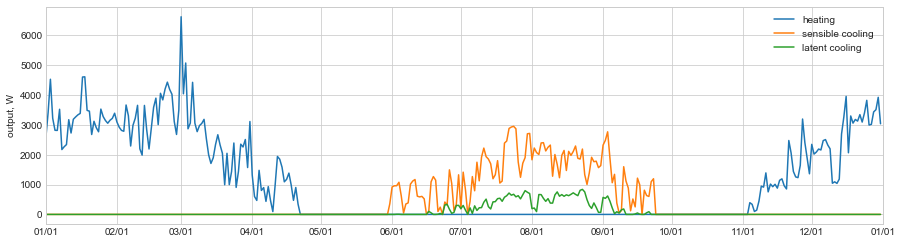

In [23]:
q_hs_cap_h = cs.get_heat_source_heating_capacity(theta_ex, h_ex, operation, theta_hs_out_h, theta_hs_in, v_supply)
q_hs_cap_c, q_hs_cap_cs, q_hs_cap_cl = cs.get_heat_source_cooling_capacity(
    theta_hs_in, x_hs_in, theta_hs_out_c, x_hs_out_c, v_supply, operation)
ac.draw_graph(y_title='output, W', ys=[
    (q_hs_cap_h, 'heating'),
    (q_hs_cap_cs, 'sensible cooling'),
    (q_hs_cap_cl, 'latent cooling')
], op='ave')

## 4. 冷凍サイクルの理論効率

### 暖房

日付 $d$ の時刻 $t$ における冷凍サイクルの理論暖房効率 $e_{comp,th,H,d,t}$ は、外気温度 $ \theta_{ex} $ に日付 $d$ の時刻 $t$ における外気温度 $ \theta_{ex,d,t} $、熱源機の風量 $ V_{hs} $ は日付 $d$ の時刻 $t$ における吹き出し風量 $V_{supply,d,t}$、熱源機入口温度 $ \theta_{hs,in,H} $は、日付 $d$ の時刻 $t$ における熱源機の入口空気温度 $\theta_{hs,in,d,t}$、熱源機出口温度 $ \theta_{hs,out,H} $は、日付 $d$ の時刻 $t$ における熱源機の出口空気温度 $\theta_{hs,out,d,t}$に等しいとして、冷凍サイクルの計算（モジュール exp_theoretical_efficiency の「暖房エネルギー消費量評価時」の計算を参照）により求まるものとする。

In [24]:
e_comp_th_h, theta_ref_evp_h, theta_ref_cnd_h = cs.get_e_th_h(
    operation=operation, theta_hs_in_h=theta_hs_in, theta_hs_out_h=theta_hs_out_h, v_hs=np.sum(v_supply, axis=0), theta_ex=theta_ex)

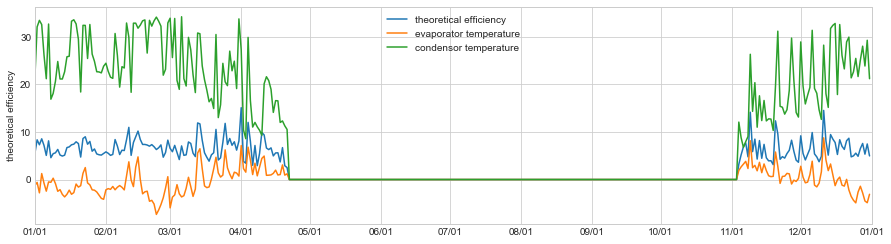

In [25]:
ac.draw_graph(y_title='theoretical efficiency', ys=[
    (e_comp_th_h, 'theoretical efficiency'),
    (theta_ref_evp_h, 'evaporator temperature'),
    (theta_ref_cnd_h, 'condensor temperature')
], op='ave')

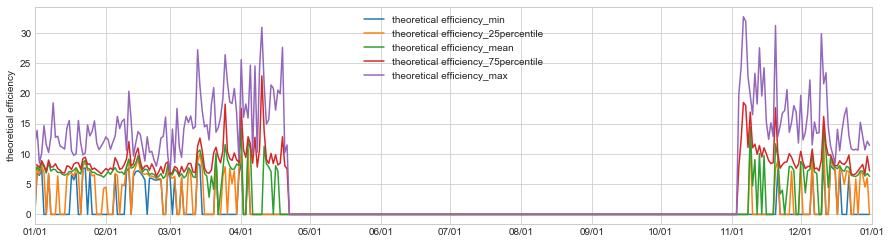

In [26]:
ac.draw_graph(y_title='theoretical efficiency', ys=[
    (e_comp_th_h, 'theoretical efficiency'),
], op='a5')

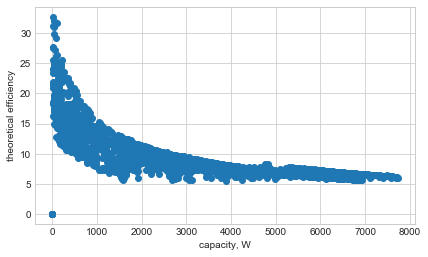

In [27]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(15,4))

ax1 = fig.add_subplot(121)
ax1.scatter(q_hs_cap_h, e_comp_th_h)

ax1.set_xlabel('capacity, W')
ax1.set_ylabel('theoretical efficiency')

plt.show()

### 冷房

日付 $d$ の時刻 $t$ における冷凍サイクルの理論冷房効率 $e_{comp,th,C,d,t}$ は、外気温度 $ \theta_{ex} $ に日付 $d$ の時刻 $t$ における外気温度 $ \theta_{ex,d,t} $、熱源機の風量 $ V_{hs} $ は日付 $d$ の時刻 $t$ における吹き出し風量 $V_{supply,d,t}$、熱源機入口温度 $ \theta_{hs,in,C} $は、日付 $d$ の時刻 $t$ における熱源機の入口空気温度 $\theta_{hs,in,d,t}$、熱源機入口絶対湿度 $ X_{hs,in,C} $は、日付 $d$ の時刻 $t$ における熱源機の入口空気絶対湿度 $X_{hs,in,d,t}$、熱源機出口温度 $ \theta_{hs,out,C} $は、日付 $d$ の時刻 $t$ における熱源機の出口空気温度 $\theta_{hs,out,d,t}$に等しいとして、冷凍サイクルの計算（モジュール exp_theoretical_efficiency の「暖房エネルギー消費量評価時」の計算を参照）により求まるものとする。

In [28]:
e_comp_th_c, theta_ref_evp_c, theta_ref_cnd_c = cs.get_e_th_c(
    operation=operation, theta_hs_in_c=theta_hs_in, x_hs_in_c=x_hs_in, theta_hs_out_c=theta_hs_out_c,
    v_hs=np.sum(v_supply, axis=0), theta_ex=theta_ex)

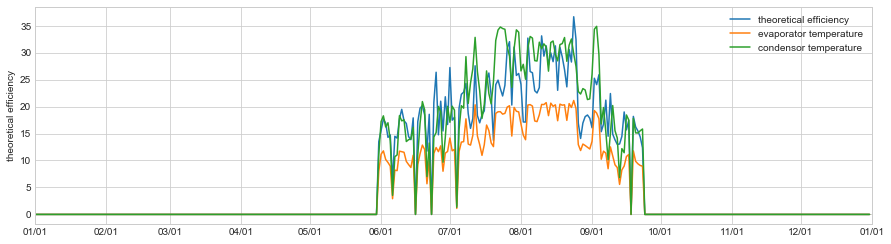

In [29]:
ac.draw_graph(y_title='theoretical efficiency', ys=[
    (e_comp_th_c, 'theoretical efficiency'),
    (theta_ref_evp_c, 'evaporator temperature'),
    (theta_ref_cnd_c, 'condensor temperature'),
], op='ave')

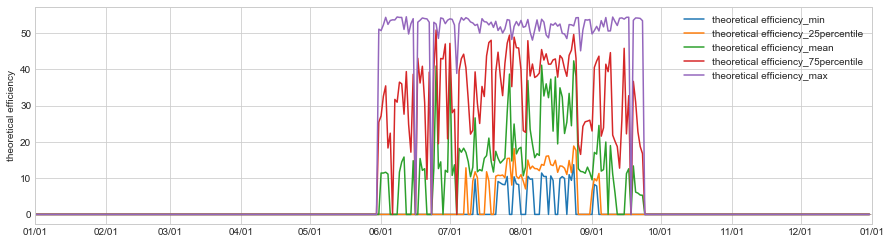

In [30]:
ac.draw_graph(y_title='theoretical efficiency', ys=[
    (e_comp_th_c, 'theoretical efficiency'),
], op='a5')

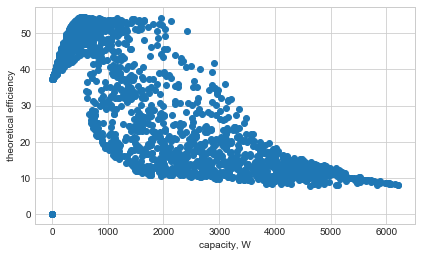

In [31]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(15,4))

ax1 = fig.add_subplot(121)
ax1.scatter(q_hs_cap_cs, e_comp_th_c)

ax1.set_xlabel('capacity, W')
ax1.set_ylabel('theoretical efficiency')

plt.show()

## 5. 圧縮効率

### 暖房

$q_{hs,cap,H,d,t} \le q_{hs,min,H}$の場合

$$ \eta_{comp,H,d,t} = \eta_{comp,min,H} - (q_{hs,min,H} - q_{hs,cap,H,d,t}) \times \frac{\eta_{comp,min,H}}{q_{hs,min,H}} $$

$q_{hs,min,H} < q_{hs,cap,H,d,t} \le q_{hs,mid,H} $の場合

$$ \eta_{comp,H,d,t} = \eta_{comp,mid,H} - (q_{hs,mid,H} - q_{hs,cap,H,d,t}) \times \frac{\eta_{comp,mid,H} - \eta_{comp,min,H}}{q_{hs,mid,H} - q_{hs,min,H}} $$

$q_{hs,mid,H} < q_{hs,cap,H,d,t} \le q_{hs,rtd,H} $の場合

$$ \eta_{comp,H,d,t} = \eta_{comp,rtd,H} - (q_{hs,rtd,H} - q_{hs,cap,H,d,t}) \times \frac{\eta_{comp,rtd,H} - \eta_{comp,mid,H}}{q_{hs,rtd,H} - q_{hs,mid,H}} $$

$q_{hs,rtd,H} < q_{hs,cap,H,d,t}$の場合

$$ \eta_{comp,H,d,t} = max \left( 0.4, \: \eta_{comp,rtd,H} - (q_{hs,cap,H,d,t} - q_{hs,rtd,H}) \times \frac{\eta_{comp,rtd,H}}{q_{hs,rtd,H}} \right) $$

$\eta_{comp,H,d,t}$：日付 $d$ の時刻 $t$ における暖房時の圧縮機の圧縮機の圧縮効率  
$\eta_{comp,mid,H}$：中間暖房能力運転時における圧縮機の圧縮効率  
$\eta_{comp,min,H}$：最小暖房能力運転時における圧縮機の圧縮効率  
$\eta_{comp,rtd,H}$：定格暖房能力運転時における圧縮機の圧縮効率   
$q_{hs,cap,H,d,t}$：日付 $d$ の時刻 $t$ における1時間当たりの熱源機の平均暖房能力, W  
$q_{hs,mid,H}$：空調機の中間暖房能力, W   
$q_{hs,min,H}$：空調機の最小暖房能力, W   
$q_{hs,rtd,H}$：空調機の定格暖房能力, W 

In [32]:
eta_comp_h = cs.get_eta_comp_h(q_hs_h=q_hs_cap_h, eta_comp_min_h=eta_comp_min_h, eta_comp_mid_h=eta_comp_mid_h, eta_comp_rtd_h=eta_comp_rtd_h,
                  q_hs_min_h=q_min_h, q_hs_mid_h=q_mid_h, q_hs_rtd_h=q_rtd_h)

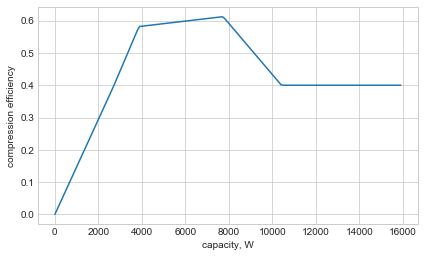

In [33]:
q = np.arange(start=0.0,stop=16000.0, step=100.0)

plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(15,4))

ax1 = fig.add_subplot(121)
ax1.plot(
    q,
    cs.get_eta_comp_h(
        q_hs_h=q, eta_comp_min_h=eta_comp_min_h, eta_comp_mid_h=eta_comp_mid_h, eta_comp_rtd_h=eta_comp_rtd_h,
        q_hs_min_h=q_min_h, q_hs_mid_h=q_mid_h, q_hs_rtd_h=q_rtd_h))

ax1.set_xlabel('capacity, W')
ax1.set_ylabel('compression efficiency')

plt.show()

### 冷房

$q_{hs,cap,C,d,t} \le q_{hs,C,min}$の場合

$$ \eta_{comp,C,d,t} = \eta_{comp,C,min} - (q_{hs,C,min} - q_{hs,cap,C,d,t}) \times \frac{\eta_{comp,C,min}}{q_{hs,C,min}} $$

$q_{hs,C,min} < q_{hs,cap,C,d,t} \le q_{hs,C,mid} $の場合

$$ \eta_{comp,C,d,t} = \eta_{comp,C,mid} - (q_{hs,C,mid} - q_{hs,cap,C,d,t}) \times \frac{\eta_{comp,C,mid} - \eta_{comp,C,min}}{q_{hs,C,mid} - q_{hs,C,min}} $$

$q_{hs,C,mid} < q_{hs,cap,C,d,t} \le q_{hs,C,rtd} $の場合

$$ \eta_{comp,C,d,t} = \eta_{comp,C,rtd} - (q_{hs,C,rtd} - q_{hs,cap,C,d,t}) \times \frac{\eta_{comp,C,rtd} - \eta_{comp,C,mid}}{q_{hs,C,rtd} - q_{hs,C,mid}} $$

$q_{hs,C,rtd} < q_{hs,cap,C,d,t}$の場合

$$ \eta_{comp,C,d,t} = max \left( 0.4, \: \eta_{comp,C,rtd} - (q_{hs,cap,C,d,t} - q_{hs,C,rtd}) \times \frac{\eta_{comp,C,rtd}}{q_{hs,C,rtd}} \right) $$

$\eta_{comp,C,d,t}$：日付 $d$ の時刻 $t$ における冷房時の圧縮機の圧縮機の圧縮効率  
$\eta_{comp,C,mid}$：中間冷房能力運転時における圧縮機の圧縮効率  
$\eta_{comp,C,min}$：最小冷房能力運転時における圧縮機の圧縮効率  
$\eta_{comp,C,rtd}$：定格冷房能力運転時における圧縮機の圧縮効率   
$q_{hs,cap,C,d,t}$：日付 $d$ の時刻 $t$ における1時間当たりの熱源機の平均冷房全熱能力, W  
$q_{hs,C,mid}$：空調機の中間冷房能力, W   
$q_{hs,C,min}$：空調機の最小冷房能力, W   
$q_{hs,C,rtd}$：空調機の定格冷房能力, W 

In [34]:
eta_comp_c = cs.get_eta_comp_c(q_hs_c=q_hs_cap_c, eta_comp_min_c=eta_comp_min_c, eta_comp_mid_c=eta_comp_mid_c, eta_comp_rtd_c=eta_comp_rtd_c,
                  q_hs_min_c=q_min_c, q_hs_mid_c=q_mid_c, q_hs_rtd_c=q_rtd_c)

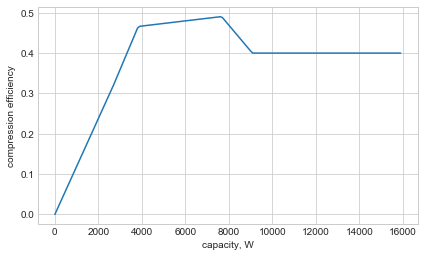

In [35]:
q = np.arange(start=0.0,stop=16000.0, step=100.0)

plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(15,4))

ax1 = fig.add_subplot(121)
ax1.plot(
    q,
    cs.get_eta_comp_c(
        q_hs_c=q, eta_comp_min_c=eta_comp_min_c, eta_comp_mid_c=eta_comp_mid_c, eta_comp_rtd_c=eta_comp_rtd_c,
        q_hs_min_c=q_min_c, q_hs_mid_c=q_mid_c, q_hs_rtd_c=q_rtd_c))

ax1.set_xlabel('capacity, W')
ax1.set_ylabel('compression efficiency')

plt.show()

## 6. 圧縮機の効率

$$ e_{comp,H,d,t} = e_{comp,th,H,d,t} \eta_{comp,H,d,t} $$
$$ e_{comp,C,d,t} = e_{comp,th,C,d,t} \eta_{comp,C,d,t} $$

$e_{comp,H,d,t}$：日付 $d$ の時刻 $t$ における圧縮機の暖房効率  
$e_{comp,th,H,d,t}$：日付 $d$ の時刻 $t$ における冷凍サイクルの理論暖房効率  
$\eta_{comp,H,d,t}$：日付 $d$ の時刻 $t$ における暖房時の圧縮機の圧縮機の圧縮効率  
$e_{comp,C,d,t}$：日付 $d$ の時刻 $t$ における圧縮機の冷房効率  
$e_{comp,th,C,d,t}$：日付 $d$ の時刻 $t$ における冷凍サイクルの理論暖房効率  
$\eta_{comp,C,d,t}$：日付 $d$ の時刻 $t$ における暖房時の圧縮機の圧縮機の圧縮効率  

In [36]:
e_comp_h = cs.get_e_comp_h(e_comp_th_h, eta_comp_h)
e_comp_c = cs.get_e_comp_c(e_comp_th_c, eta_comp_c)

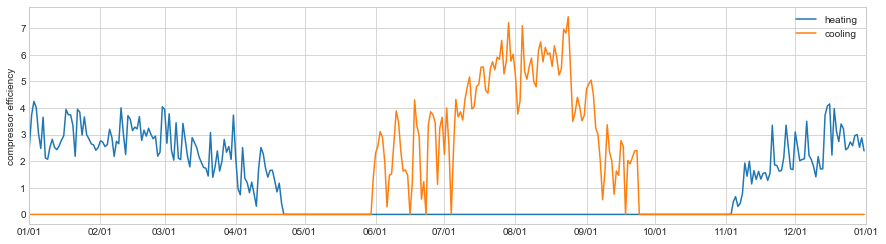

In [37]:
ac.draw_graph(y_title='compressor efficiency', ys=[
    (e_comp_h, 'heating'),
    (e_comp_c, 'cooling'),
], op='ave')

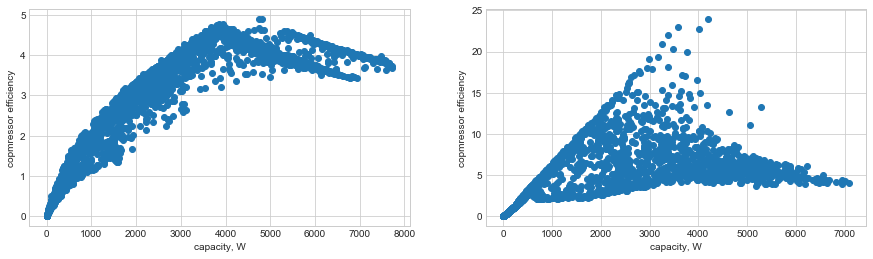

In [38]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(15,4))

ax1 = fig.add_subplot(121)
ax1.scatter(q_hs_cap_h, e_comp_h)
ax1.set_xlabel('capacity, W')
ax1.set_ylabel('copmressor efficiency')

ax2 = fig.add_subplot(122)
ax2.scatter(q_hs_cap_c, e_comp_c)
ax2.set_xlabel('capacity, W')
ax2.set_ylabel('copmressor efficiency')

plt.show()

## 7. 圧縮機の消費電力

$$ E_{E,comp,H,d,t} = \frac{q_{hs,cap,H,d,t}}{e_{comp,H,d,t}} \times 10^{-3} $$
$$ E_{E,comp,C,d,t} = \frac{q_{hs,cap,C,d,t}}{e_{comp,C,d,t}} \times 10^{-3} $$

$E_{E,comp,H,d,t}$：日付 $d$ の時刻 $t$ における暖房時の1時間当たりの圧縮機の消費電力量, kWh/h  
$E_{E,comp,C,d,t}$：日付 $d$ の時刻 $t$ における冷房時の1時間当たりの圧縮機の消費電力量, kWh/h  
$q_{hs,cap,H,d,t}$：日付 $d$ の時刻 $t$ における1時間当たりの熱源機の平均暖房能力, W  
$q_{hs,cap,C,d,t}$：日付 $d$ の時刻 $t$ における1時間当たりの熱源機の平均冷房全熱能力, W  
$e_{comp,H,d,t}$：日付 $d$ の時刻 $t$ における圧縮機の暖房効率  
$e_{comp,C,d,t}$：日付 $d$ の時刻 $t$ における圧縮機の冷房効率  

In [39]:
e_e_comp_h = cs.get_e_e_comp_h(q_hs_cap_h, e_comp_h)
e_e_comp_c = cs.get_e_e_comp_c(q_hs_cap_c, e_comp_c)

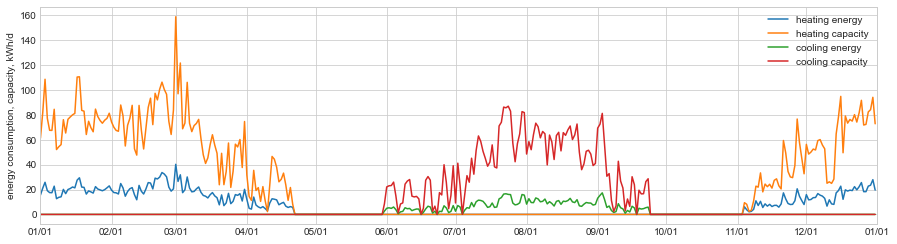

In [40]:
ac.draw_graph(y_title='energy consumption, capacity, kWh/d', ys=[
    (e_e_comp_h, 'heating energy'),
    (q_hs_cap_h * 10**(-3), 'heating capacity'),
    (e_e_comp_c, 'cooling energy'),
    (q_hs_cap_c * 10**(-3), 'cooling capacity'),
], op='itg')

## 8. 送風機の消費電力

本システムが換気を含む場合

$$ E_{E,fan,H,d,t} = (P_{fan,rtd,H} - f_{SFP} \sum_i{V_{vent,i}}) \frac{ \sum_i{V_{supply,d,t,i}} - \sum_i{V_{vent,i}} }{ V_{fan,rtd,H} - \sum_i{V_{vent,i}} } \times 10^{-3} $$

$$ E_{E,fan,C,d,t} = (P_{fan,rtd,C} - f_{SFP} \sum_i{V_{vent,i}}) \frac{ \sum_i{V_{supply,d,t,i}} - \sum_i{V_{vent,i}} }{ V_{fan,rtd,C} - \sum_i{V_{vent,i}} } \times 10^{-3} $$

本システムが換気を含む場合

$$ E_{E,fan,H,d,t} = P_{fan,rtd,H} \frac{ \sum_i{V_{supply,d,t,i}} - \sum_i{V_{vent,i}} }{ V_{fan,rtd,H} } \times 10^{-3} $$

$$ E_{E,fan,C,d,t} = P_{fan,rtd,C} \frac{ \sum_i{V_{supply,d,t,i}} - \sum_i{V_{vent,i}} }{ V_{fan,rtd,C} } \times 10^{-3} $$

ただし、  
$E_{E,fan,H,d,t} \lt 0$ の場合は、$E_{E,fan,H,d,t} = 0$  
$E_{E,fan,C,d,t} \lt 0$ の場合は、$E_{E,fan,C,d,t} = 0$  
とする。  
また、
「暖房運転中」以外の場合は$E_{E,fan,H,d,t} = 0$、「冷房運転中」以外の場合は$E_{E,fan,C,d,t} = 0$である。

$E_{E,fan,H,d,t}$：日付 $d$ の時刻 $t$ における1時間当たりの送風機の消費電力量のうちの暖房設備への付加分, kWh/h  
$E_{E,fan,C,d,t}$：日付 $d$ の時刻 $t$ における1時間当たりの送風機の消費電力量のうちの冷房設備への付加分, kWh/h  
$P_{fan,rtd,H}$：定格暖房能力運転時における送風機の消費電力, W   
$P_{fan,rtd,C}$：定格冷房能力運転時における送風機の消費電力, W   
$V_{vent,i}$：暖冷房区画 $i$ の機械換気量, m<sup>3</sup>/h  
$f_{SFP}$：全般換気設備の比消費電力, W/(m<sup>3</sup>/h) ( = 0.4 ✕ 0.36)  
$V_{supply,d,t,i}$：日付 $d$ の時刻 $t$ における暖冷房区画 $i$ への吹き出し風量, m<sup>3</sup>/h    
$V_{fan,rtd,H}$：定格暖房能力運転時における熱源機の風量, m<sup>3</sup>/h  
$V_{fan,rtd,C}$：定格冷房能力運転時における熱源機の風量, m<sup>3</sup>/h  

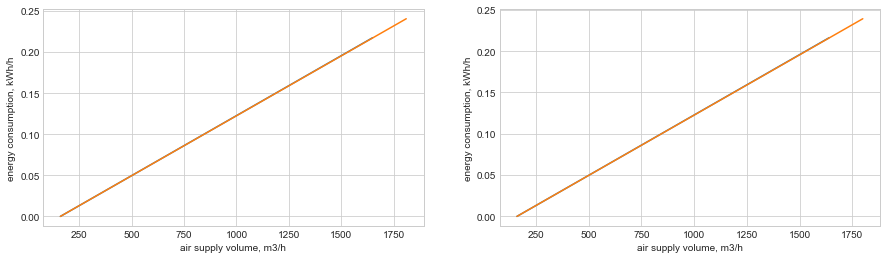

In [41]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(15,4))

ax1 = fig.add_subplot(121)
vh1 = np.array([np.arange(start=np.sum(v_vent),stop=v_hs_rtd_h, step=10.0)])
vh2 = np.array([np.arange(start=np.sum(v_vent),stop=v_hs_rtd_h+np.sum(v_vent), step=10.0)])
ax1.plot(np.sum(vh1,axis=0), cs.get_e_e_fan_h('h', True, p_fan_rtd_h, v_vent, vh1, v_hs_rtd_h))
ax1.plot(np.sum(vh2,axis=0), cs.get_e_e_fan_h('h', False, p_fan_rtd_h, v_vent, vh2, v_hs_rtd_h))
ax1.set_xlabel('air supply volume, m3/h')
ax1.set_ylabel('energy consumption, kWh/h')

ax2 = fig.add_subplot(122)
vc1 = np.array([np.arange(start=np.sum(v_vent),stop=v_hs_rtd_c, step=10.0)])
vc2 = np.array([np.arange(start=np.sum(v_vent),stop=v_hs_rtd_c+np.sum(v_vent), step=10.0)])
ax2.plot(np.sum(vc1,axis=0), cs.get_e_e_fan_c('c', True, p_fan_rtd_c, v_vent, vc1, v_hs_rtd_c))
ax2.plot(np.sum(vc2,axis=0), cs.get_e_e_fan_c('c', False, p_fan_rtd_c, v_vent, vc2, v_hs_rtd_c))
ax2.set_xlabel('air supply volume, m3/h')
ax2.set_ylabel('energy consumption, kWh/h')

plt.show()

In [42]:
e_e_fan_h = cs.get_e_e_fan_h(operation, is_duct_insulated, p_fan_rtd_h, v_vent, v_supply, v_hs_rtd_h)
e_e_fan_c = cs.get_e_e_fan_c(operation, is_duct_insulated, p_fan_rtd_c, v_vent, v_supply, v_hs_rtd_c)

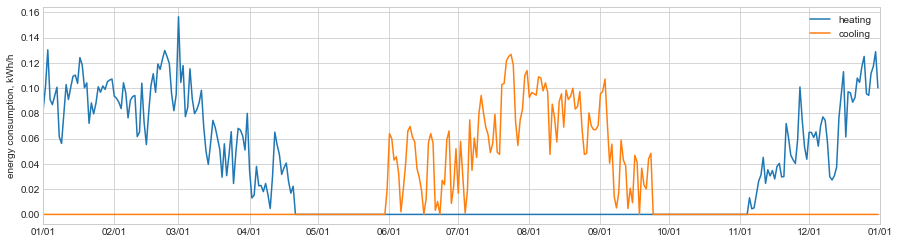

In [43]:
ac.draw_graph(y_title='energy consumption, kWh/h', ys=[
    (e_e_fan_h, 'heating'),
    (e_e_fan_c, 'cooling'),
], op='ave')

## 9. 消費電力

$$ E_{E,H,d,t} = E_{E,comp,H,d,t} + E_{E,fan,H,d,t} $$

$E_{E,H,d,t}$：日付 $d$ の時刻 $t$ における1時間当たりの暖房の消費電力量, kWh/h  
$E_{E,fan,H,d,t}$：日付 $d$ の時刻 $t$ における1時間当たりの送風機の消費電力量のうちの暖房設備への付加分, kWh/h  
$E_{E,comp,H,d,t}$：日付 $d$ の時刻 $t$ における暖房時の1時間当たりの圧縮機の消費電力量, kWh/h  

$$ E_{E,C,d,t} = E_{E,comp,C,d,t} + E_{E,fan,C,d,t}  $$

$E_{E,C,d,t}$：日付 $d$ の時刻 $t$ における1時間当たりの冷房の消費電力量, kWh/h  
$E_{E,fan,C,d,t}$：日付 $d$ の時刻 $t$ における1時間当たりの送風機の消費電力量のうちの冷房設備への付加分, kWh/h  
$E_{E,comp,C,d,t}$：日付 $d$ の時刻 $t$ における冷房時の1時間当たりの圧縮機の消費電力量, kWh/h  


In [44]:
e_e_h = cs.get_e_e_h(e_e_comp_h, e_e_fan_h)
e_e_c = cs.get_e_e_c(e_e_comp_c, e_e_fan_c)

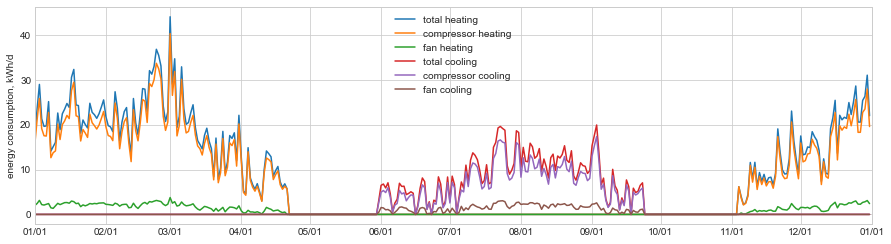

In [45]:
ac.draw_graph(y_title='energy consumption, kWh/d', ys=[
    (e_e_h, 'total heating'),
    (e_e_comp_h, 'compressor heating'),
    (e_e_fan_h, 'fan heating'),
    (e_e_c, 'total cooling'),
    (e_e_comp_c, 'compressor cooling'),
    (e_e_fan_c, 'fan cooling'),
], op='itg')

## 10. 一次エネルギー消費量

$$ E_{H,T,d,t} = E_{E,H,d,t} f_{prim} \times 10^{-3} $$

$$ E_{H,UT,d,t} = \sum_i{Q_{UT,H,d,t,i}} \alpha_{UT,H} $$

$E_{H,T,d,t}$：日付 $d$ の時刻 $t$ における1時間当たりの暖房設備の設計一次エネルギー消費量, MJ/h  
$E_{H,UT,d,t}$：日付 $d$ の時刻 $t$ における1時間当たりの暖房設備の未処理暖房負荷の設計一次エネルギー消費量相当値, MJ/h  
$E_{E,H,d,t}$：日付 $d$ の時刻 $t$ における1時間当たりの暖房の消費電力量, kWh/h  
$f_{prim}$：電気の量1kWhを熱量に換算する係数(=9760), kJ/kWh  
$Q_{UT,H,d,t,i}$：日付 $d$ の時刻 $t$ における1時間当たりの暖冷房区画 $i$ に設置された暖房設備機器等の未処理暖房負荷, MJ/h  
$\alpha_{UT,H}$：暖房設備の未処理暖房負荷を未処理暖房負荷の設計一次エネルギー消費量に相当値に換算するための係数  

$$ E_{C,T,d,t} = E_{E,C,d,t} f_{prim} \times 10^{-3} $$

$$ E_{C,UT,d,t} = \sum_i{(Q_{UT,CS,d,t,i} + Q_{UT,CL,d,t,i})} \alpha_{UT,C} $$

$E_{C,T,d,t}$：日付 $d$ の時刻 $t$ における1時間当たりの冷房設備の設計一次エネルギー消費量, MJ/h  
$E_{C,UT,d,t}$：日付 $d$ の時刻 $t$ における1時間当たりの冷房設備の未処理暖房負荷の設計一次エネルギー消費量相当値, MJ/h  
$E_{E,C,d,t}$：日付 $d$ の時刻 $t$ における1時間当たりの冷房の消費電力量, kWh/h  
$f_{prim}$：電気の量1kWhを熱量に換算する係数(=9760), kJ/kWh  
$Q_{UT,CS,d,t,i}$：日付 $d$ の時刻 $t$ における1時間当たりの暖冷房区画 $i$ に設置された冷房設備機器の未処理冷房顕熱負荷, MJ/h  
$Q_{UT,CL,d,t,i}$：日付 $d$ の時刻 $t$ における1時間当たりの暖冷房区画 $i$ に設置された冷房設備機器の未処理冷房潜熱負荷, MJ/h  
$\alpha_{UT,C}$：冷房設備の未処理暖房負荷を未処理暖房負荷の設計一次エネルギー消費量に相当値に換算するための係数  

暖冷房設備の未処理暖房負荷を未処理暖房負荷の設計一次エネルギー消費量に相当値に換算するための係数  

| 地域 | 暖房 | 冷房 |
| --- | --- | --- |
| 1 | 1.61 | 1.0 |
| 2 | 1.46 | 1.0 |
| 3 | 1.32 | 1.0 |
| 4 | 1.30 | 1.0 |
| 5 | 1.20 | 1.0 |
| 6 | 1.09 | 1.0 |
| 7 | 1.12 | 1.0 |
| 8 | - | 1.0 |

In [46]:
e_h_t, e_h_ut, e_c_t, e_c_ut = cs.get_e(case['region'], e_e_h, e_e_c, q_ut_h, q_ut_cs, q_ut_cl)

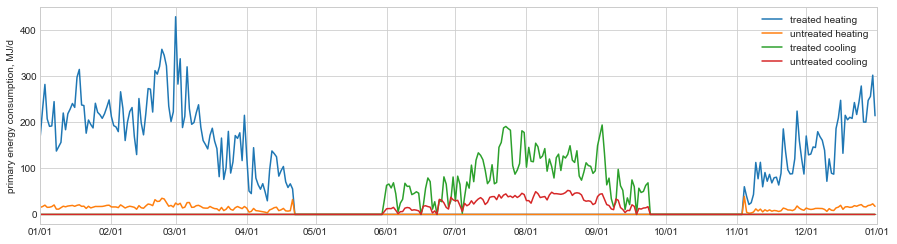

In [47]:
ac.draw_graph(y_title='primary energy consumption, MJ/d', ys=[
    (e_h_t, 'treated heating'),
    (e_h_ut, 'untreated heating'),
    (e_c_t, 'treated cooling'),
    (e_c_ut, 'untreated cooling'),
], op='itg')